Interactively figure out MGRS tiles and track numbers

In [38]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [72]:
yaml_file = 'events/bioko_fire_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'bioko_fire_2024',
 'bounds': [107.29793288, -6.9549793, 107.32434909, -6.92756748],
 'event_date': '2024-02-07',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [98, 149],
 'mgrs_tiles': ['32NMJ'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange - Sentinel-2',
 'links': ['data: https://data.humdata.org/dataset/areas-burned-from-february-3rd-to-18th-2024-around-the-pico-basil-volcano-on-bioko-island-',
  'https://go.ifrc.org/emergencies/6858/details']}

# Read Geojson

In [64]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

In [65]:
# df_event.plot()

In [66]:
df_event.head()

,name,date,source_id,geometry
0,bioko_fire_2024,2024-02-07,UNOSAT via humanitarian data exchange,"MULTIPOLYGON (((8.75802 3.56722, 8.75793 3.567..."


In [67]:
df_event.total_bounds

array([8.73555504, 3.56664088, 8.7688816 , 3.59751284])

# Create Spatial AOI

In [68]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [69]:
bounds = aoi.bounds
bounds

(8.735555044976296, 3.566640878998406, 8.768881598000064, 3.597512838000057)

# Find MGRS tiles and Explore

In [70]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(179, -60, 180, 60))]

df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
2,32NMJ,32632,"MULTIPOLYGON(((399960 400020,399960 290220,509...","MULTIPOLYGON (((8.09922 3.61861, 8.10006 2.625..."
3,32NMK,32632,"MULTIPOLYGON(((399960 500040,399960 390240,509...","MULTIPOLYGON (((8.09821 4.52336, 8.09931 3.530..."


In [73]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [74]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['32NMJ']

In [75]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

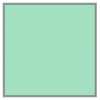

In [76]:
search_geo

# Explore Availability of RTC Data

In [77]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [78]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

370

In [79]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

216

In [80]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [81]:
df_rtc_resp_pre_e.pathNumber.unique()

array([132, 124,  51,  30])

In [83]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
# df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([30, 51])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [62]:
df_rtc_resp_post_e.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,validityStartDate,subswath,fileName,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter
0,"POLYGON ((24.00433 38.73631, 24.56472 38.81909...",38.898098,24.523736,2024-08-15T16:16:10Z,OPERA_L2_RTC-S1_T029-060371-IW1_20240815T16160...,ASCENDING,29,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-15T16:16:07Z,...,None,IW1,OPERA_L2_RTC-S1_T029-060371-IW1_20240815T16160...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
1,"POLYGON ((24.04361 38.57022, 24.60456 38.65327...",38.732593,24.564540,2024-08-15T16:16:07Z,OPERA_L2_RTC-S1_T029-060370-IW1_20240815T16160...,ASCENDING,29,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-15T16:16:04Z,...,None,IW1,OPERA_L2_RTC-S1_T029-060370-IW1_20240815T16160...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
2,"POLYGON ((24.08231 38.40417, 24.64428 38.48757...",38.566672,24.603299,2024-08-15T16:16:04Z,OPERA_L2_RTC-S1_T029-060369-IW1_20240815T16160...,ASCENDING,29,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-15T16:16:01Z,...,None,IW1,OPERA_L2_RTC-S1_T029-060369-IW1_20240815T16160...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
3,"POLYGON ((24.12190 38.23813, 24.68394 38.32173...",38.400778,24.642090,2024-08-15T16:16:02Z,OPERA_L2_RTC-S1_T029-060368-IW1_20240815T16155...,ASCENDING,29,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-15T16:15:59Z,...,None,IW1,OPERA_L2_RTC-S1_T029-060368-IW1_20240815T16155...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
4,"POLYGON ((24.16288 38.07205, 24.72357 38.15564...",38.234784,24.681438,2024-08-15T16:15:59Z,OPERA_L2_RTC-S1_T029-060367-IW1_20240815T16155...,ASCENDING,29,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-15T16:15:56Z,...,None,IW1,OPERA_L2_RTC-S1_T029-060367-IW1_20240815T16155...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
